In [96]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [103]:
data = pd.read_csv('./sw_classifications_20160526-afterdedupe.csv')

In [104]:
data.head()

,swi_id,swj_id,swi_geom,swj_geom,connected,username,timestamp
0,309963,317735,010200000002000000FB3CEA9DC7935EC08902972360CC...,010200000002000000699C891DF0935EC060CB94877CCC...,f,Sumit,2016-05-24 02:29:15.820404+00
1,313312,313373,010200000002000000A2BCE99980925EC0D7DE25935DCC...,010200000002000000182B66EE92925EC00F6FA3F743CC...,t,Annie T,2016-05-26 03:27:50.283528+00
2,304826,305160,010200000002000000E39CA78061935EC0A92043F180D6...,010200000002000000CB14431650935EC00E56906ABAD6...,f,Annie T,2016-05-26 03:44:58.635554+00
3,306273,306938,010200000002000000C9C226BCB5955EC0568370BE61D8...,01020000000200000043E1C5F69E955EC058E9BFB429D8...,f,Anonymous,2016-05-26 04:24:03.041748+00
4,306373,306697,0102000000020000006F1D84D861925EC065187A35F8D6...,01020000000200000027997E7153925EC0A637A03531D7...,f,sophia,2016-05-26 05:12:59.299378+00


We want to only consider sidewalk pairs that have at least 3 labels.

In [115]:
gb = data.groupby(['swi_id', 'swj_id'])
groups = gb.groups
more_3 = {key: value for key, value in groups.iteritems() if len(value) >= 3}
more_2 = {key: value for key, value in groups.iteritems() if len(value) >= 2}
print 'Number of unique sidewalk pair labels: {}'.format(len(groups))
print 'Number of labels with more than 3 responses: {}'.format(len(more_3))
print 'Number of labels with 2 responses: {}'.format(len(have_2))

Number of unique sidewalk pair labels: 11132
Number of labels with more than 3 responses: 862
Number of labels with 2 responses: 976


The groups are a dictionary of group element + index. To get to the actual labels, we can just grab the row at that index from our data frame.

In [109]:
more_2.items()[:3]

[((314113, 317845), [576, 12067]),
 ((319030, 319031), [10246, 11306]),
 ((289754, 311059), [3297, 12875])]

In [110]:
def label_fraction(sw_labelset):
    '''
    :param sw_labelset: List of 't' (True) or 'f' (False) labels for a single sidewalk pair.
    :type sw_labelset: list
    
    '''
    tf = data.iloc[sw_labelset, :]['connected']
    fraction_t = sum([1 for label in tf if label == 't']) / float(len(sw_labelset))
    
    return fraction_t

def decide_label(fraction):
    '''Decide how to label a given sidewalk pair given multiple responses.'''
    # If majority is 't', choose 't'
    if fraction > 0.5:
        return 't'
    # If majority is 'f', choose 'f'
    elif fraction < 0.5:
        return 'f'
    # If even split, ignore entirely for now
    else:
        return None

In [124]:
fractions2 = []
labels2 = []
for key, value in more_2.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels2.append(newrow)
        fractions2.append(fraction)

labels2 = pd.DataFrame(labels)
labels2.head()

,swi_id,swj_id,connected
6276,325902,326474,f
736,326184,326185,f
2548,297773,303110,f
1925,322238,330093,f
10184,319771,320091,t


In [125]:
fractions3 = []
labels3 = []
for key, value in more_3.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels3.append(newrow)
        fractions3.append(fraction)

labels3 = pd.DataFrame(labels)
labels3.head()

,swi_id,swj_id,connected
6276,325902,326474,f
736,326184,326185,f
2548,297773,303110,f
1925,322238,330093,f
10184,319771,320091,t


In [126]:
labels2['connected'].describe()

count     1793
unique       2
top          f
freq      1404
Name: connected, dtype: object

In [127]:
labels3['connected'].describe()

count     1793
unique       2
top          f
freq      1404
Name: connected, dtype: object

(array([ 655.,    0.,    0.,   14.,    0.,    0.,   14.,    0.,    0.,  179.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

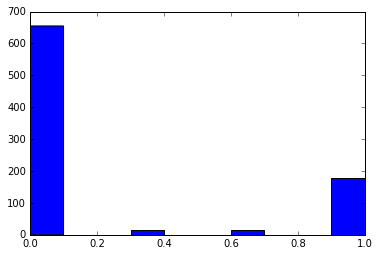

In [128]:
plt.hist(fractions3)

In [129]:
uncontested = [f for f in fractions3 if f != 0 and f != 1]
len(uncontested) / float(len(fractions3))

0.03248259860788863

'labels2' contains all majority-rule labels that have 2 or more responses. 'labels3' contains all majority-rule labels that have 3 or more responses.